In [21]:
from dataset import (
    BuildingDataset,
    show_segmentation,
    data_loaders,
    show_segmentation_v2,
)
from model import ModelConfig, new_model, TwoMLPRegression
from dataset import NUMBER_OF_CLASSES
import dataset
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch

In [ ]:
# Load data for exploration.
dataset_expl = BuildingDataset(
    "datasets/mlc_training_data/images_annotated/",
)

# data = [d for d in dataset_expl]
data = [dataset_expl[i] for i in range(10)]

In [ ]:
for sample in data[:10]:
    img, pred_masks, boxes = sample[0], sample[1]["masks"], sample[1]["boxes"]
    height_labels = [str(h.item()) for h in sample[1]["building_heights"]]
    show_segmentation(img, pred_masks, boxes, height_labels)

In [ ]:
def show_distribution(values, bins=None):
    counts, bins = np.histogram(
        values,
        bins=bins,
    )
    plt.stairs(counts, bins, fill=True)

    print("Min: ", pred_masks.min(), "Max: ", pred_masks.max())

    for q in [0.25, 0.5, 0.75, 0.95, 0.99]:
        print(f"Quantile {q}: {np.quantile(values, q)}")


# heights = [d[1]["building_heights"] for d in data]
# heights = np.stack(heights, axis=0)
# show_distribution(heights, [3, 6, 9, 15, 25, 40, 70, 120, 200, max(250, heights.max())])

pred_masks = [len(d[1]["masks"]) for d in data]
pred_masks = np.stack(pred_masks, axis=0)
show_distribution(pred_masks, [3, 6, 9, 15, 25, 40, 70, 120, 200])

In [2]:
data_loader, _ = data_loaders(
    "datasets/mlc_training_data/images_annotated/",
)

model_cfg = ModelConfig(
    name="default_model_v2",
    num_classes=NUMBER_OF_CLASSES,
    mask_hidden_layer_size=256,
    building_height_pred=TwoMLPRegression,
    building_height_pred_loss_fn=nn.SmoothL1Loss(beta=1 / 9),
)

model = new_model(model_cfg)

checkpoint_dict = torch.load("checkpoints/default_model_epoch_1.pt")
model.load_state_dict(checkpoint_dict["model_state_dict"])


# For Training
# images, targets = next(iter(data_loader))

# images = list(image for image in images)
# targets = [{k: v for k, v in t.items()} for t in targets]
# output = model(images, targets)  # Returns losses and detections
# print(output)

INFO:root:Size of training set 1756. Sise of test set: 439


<All keys matched successfully>

dict_keys(['boxes', 'labels', 'scores', 'heights', 'masks'])


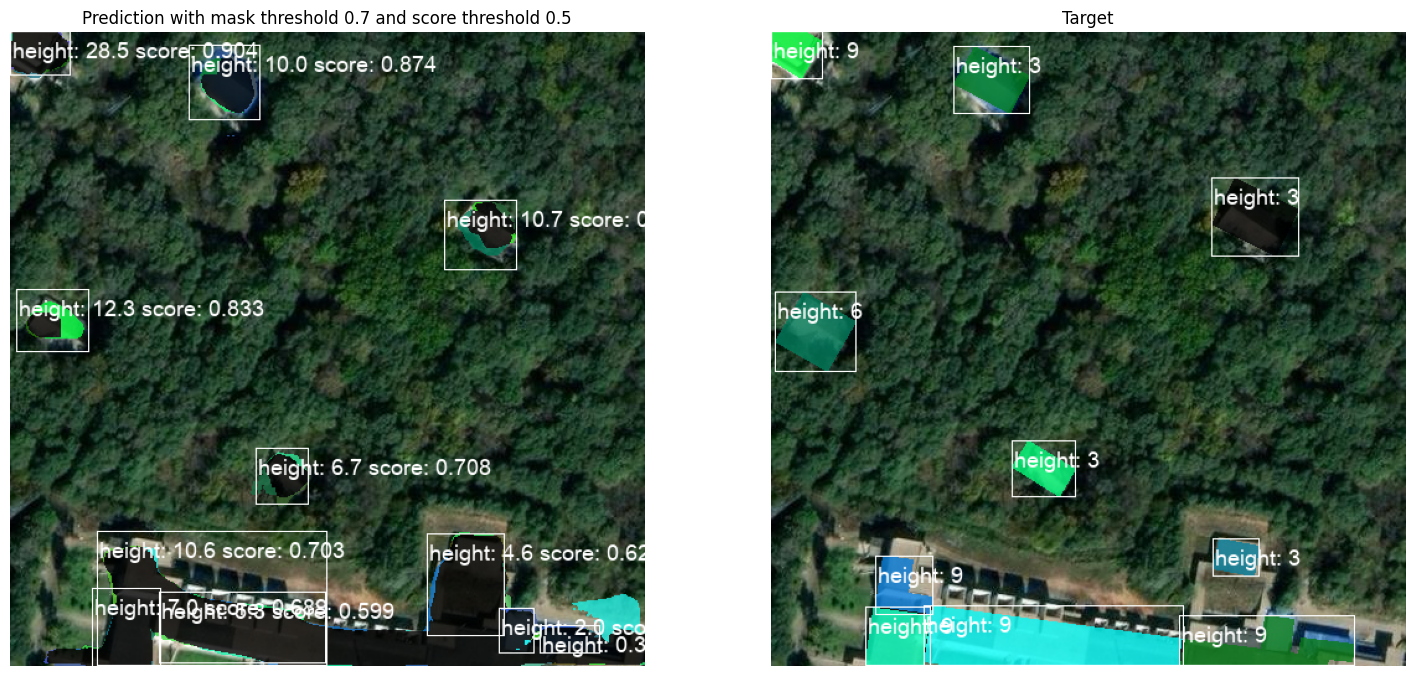

In [29]:
# For inference
# model.eval()
# inf_images, inf_targets = next(iter(data_loader))
# predictions = model(inf_images)

import importlib

importlib.reload(dataset)

MASK_THRESHOLD = 0.7
BOX_SCORE_THRESHOLD = 0.6

print(predictions[1].keys())

transform = T.Compose(
    [
        T.Lambda(lambda x: x * 255.0),  # Scale to [0, 255]
        T.Lambda(lambda x: x.to(torch.uint8)),  # Convert to uint8
    ]
)

# Apply the transform
for i, pred in enumerate(predictions[:1]):
    img = transform(inf_images[i])

    pred_masks = (pred["masks"] > MASK_THRESHOLD).squeeze(1)
    pred_scores = pred["scores"]
    selected_ids = torch.where(pred_scores > BOX_SCORE_THRESHOLD)[0]
    pred_boxes = pred["boxes"][selected_ids].long()
    pred_labels = pred["heights"][selected_ids]
    pred_scores = pred_scores[selected_ids]

    pred_labels = [
        f"height: {label:.1f} score: {score:.3f}"
        for label, score in zip(pred_labels, pred_scores)
    ]

    target_masks = inf_targets[i]["masks"]
    target_boxes = inf_targets[i]["boxes"]
    target_labels = [f"height: {h.item()}" for h in inf_targets[i]["building_heights"]]

    dataset.show_segmentation_v2(
        img,
        pred_masks,
        target_masks,
        pred_boxes,
        target_boxes,
        pred_labels,
        target_labels,
        pred_title=f"Prediction with mask threshold {MASK_THRESHOLD} and score threshold {BOX_SCORE_THRESHOLD}",
        pred_colors="white",
        target_colors="white",
        font="/Library/Fonts/Arial Unicode.ttf",
        font_size=18,
    )

In [ ]:
selected_ids = torch.where(pred["scores"] > 0.6)
boxes[selected_ids]